[**COLAB LINK**](https://colab.research.google.com/drive/1HedbK6c_X5hVo9WfsFZa811FECaclGnG)

# **The Navier-Stokes Equations**
**Edvin von Platen**

# **Abstract**

In this report we use FEniCS to solve the Navier-Stokes equations. The equations are solved over a rectangular mesh with a cylinder boundary, we compute [lift- and drag coefficients](https://en.wikipedia.org/wiki/Drag_coefficient), and the [Strouhal number](https://en.wikipedia.org/wiki/Strouhal_number), for runs with altering Reynolds number and mesh resolutions.

[DD2365 course website.](https://kth.instructure.com/courses/17071)

# **About the code**

In [0]:
"""This program is an example file for the course"""
"""DD2365 Advanced Computation in Fluid Mechanics, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Edvin von Platen (edvinvp@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [0]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time
from scipy import signal

try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common 
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

The Navier-Stokes equations take the form

$\dot u + (u\cdot \nabla)u + \nabla p -\Delta u = f,\quad \nabla \cdot u=0,$

together with suitable initial and boundary conditions.

Here we present a FEniCS implementation of a stabilized space-time finite element method to solve the Navier-Stokes equations in 2D. The solution is visualized using FEniCS plotting functions, and is also exported as pvd-files which can be visualized in Paraview.

We seek a finite element approximation $(u,p)\in V\times Q$ such that 

$(\dot u + (u\cdot \nabla)u, v) - (p,\nabla \cdot v) + (\nu \nabla u,\nabla v) + (\nabla \cdot u, q) + SD(u,p;v,q) = (f,v),$

for all test functions $(v,q) \in \hat V\times \hat Q$, where $SD(u,p;v,q)$ is a residual based stabilization term.

We present an example of flow past a circular cylinder, for which we compute the force on the surface of the cylinder $\Gamma$ in the direction $\phi$, by Green's formula: 

$
F(u,p,\phi)= ~<\nu \nabla u\cdot n-pn, \Phi>_{\Gamma} ~=~(\dot u+(u\cdot \nabla)u, \Phi) + (\nu \nabla u,\nabla \Phi) - (p,\nabla \cdot\Phi)-(f,\Phi),
$

with $\Phi\in V$ a fuinction for which $\Phi\vert _{\Gamma}=\phi$ and $\Phi\vert_{\partial \Omega \setminus \Gamma}=0$. With $\phi=(1,0)$ we get the drag force $F_D$, and with $\phi=(0,1)$ the lift force $F_L$. The drag and lift coefficients are obtained by normalization, 

$
c_D = \frac{2F_D}{\rho U^2D}, \quad c_L = \frac{2F_L}{\rho U^2D}
$

where $\rho$ is the density (here $\rho=1$), $U$ the characteristic velocity (here $U=1$), and $D$ the characteristic length scale (here $D$ is the diameter of the cylinder). 

The Reynolds number is defined as $Re=\frac{UD}{\nu}$

To read more about how to use similar methods for more complex problems, see e.g. 

[Hoffman, Johan, et al. "Towards a parameter-free method for high reynolds number turbulent flow simulation based on adaptive finite element approximation." Computer Methods in Applied Mechanics and Engineering 288 (2015): 60-74.](https://www.sciencedirect.com/science/article/pii/S0045782514004836)

We compare the simulations with Reynols numbers $RE = 1,\ 10, \ 100, \ 100$, for each simulation we will also compoute the drag and lift coefficients, and the Strouhal number. We then fix the $RE=100$ and alter the mesh resolution to $h=1/8, \ 1/16, \ 1/32$.


# **Method**

To make the simulation analysis easier we implement a simulation class.

In [0]:
class NS_Simulation:

  # setup a channel mesh with a cylinder boundary
  def setup_mesh(self, H = 2, L = 4, resolution = 32, rc = 0.2):
    self.H = H
    self.L = L
    self.resolution = 32
    # Define circle
    self.xc = 1.0
    self.yc = 0.5*H
    self.rc = rc

    # Define subdomains (for boundary conditions)
    class Left(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[0], 0.0) 

    class Right(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[0], L)

    class Lower(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[1], 0.0)

    class Upper(SubDomain):
        def inside(self, x, on_boundary):
            return near(x[1], H)
          
    self.left = Left()
    self.right = Right()
    self.lower = Lower()
    self.upper = Upper()

    #mesh = RectangleMesh(Point(0.0, 0.0), Point(L, H), L*resolution, H*resolution)
    self.mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(self.xc, self.yc), self.rc), resolution)

    # Define mesh functions (for boundary conditions)
    self.boundaries = MeshFunction("size_t", self.mesh, self.mesh.topology().dim()-1)
    self.boundaries.set_all(0)
    self.left.mark(self.boundaries, 1)
    self.right.mark(self.boundaries, 2)
    self.lower.mark(self.boundaries, 3)
    self.upper.mark(self.boundaries, 4)

  def plot_mesh(self):
    plt.figure()
    plot(self.mesh)
    plt.show()

  def setup_spaces(self):
    # Generate finite element spaces (for velocity and pressure)
    self.V = VectorFunctionSpace(self.mesh, "Lagrange", 1)
    self.Q = FunctionSpace(self.mesh, "Lagrange", 1)

    # Define trial and test functions 
    self.u = TrialFunction(self.V)
    self.p = TrialFunction(self.Q)
    self.v = TestFunction(self.V)
    self.q = TestFunction(self.Q)

  def setup_boundary(self):
    H = self.H
    L = self.L
    # Define boundary conditions 
    class DirichletBoundaryLower(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 0.0)

    class DirichletBoundaryUpper(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], H)

    class DirichletBoundaryLeft(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0.0) 

    class DirichletBoundaryRight(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], L)

    class DirichletBoundaryObjects(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], L)) and (not near(x[1], 0.0)) and (not near(x[1], H))

    dbc_lower = DirichletBoundaryLower()
    dbc_upper = DirichletBoundaryUpper()
    dbc_left = DirichletBoundaryLeft()
    dbc_right = DirichletBoundaryRight()
    dbc_objects = DirichletBoundaryObjects()

    # Examples of time dependent and stationary inflow conditions
    #uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
    #uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
    uin = 1.0
    bcu_in0 = DirichletBC(self.V.sub(0), uin, dbc_left)
    bcu_in1 = DirichletBC(self.V.sub(1), 0.0, dbc_left)
    bcu_upp0 = DirichletBC(self.V.sub(0), 0.0, dbc_upper)
    bcu_upp1 = DirichletBC(self.V.sub(1), 0.0, dbc_upper)
    bcu_low0 = DirichletBC(self.V.sub(0), 0.0, dbc_lower)
    bcu_low1 = DirichletBC(self.V.sub(1), 0.0, dbc_lower)
    bcu_obj0 = DirichletBC(self.V.sub(0), 0.0, dbc_objects)
    bcu_obj1 = DirichletBC(self.V.sub(1), 0.0, dbc_objects)

    self.pin = Expression('5.0*fabs(sin(t))', element = self.Q.ufl_element(), t=0.0)
    self.pout = 0.0
    #bcp0 = DirichletBC(self.Q, self.pin, dbc_left) 
    bcp1 = DirichletBC(self.Q, self.pout, dbc_right)

    #bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
    self.bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
    self.bcp = [bcp1]

    # Define measure for boundary integration  
    self.ds = Measure('ds', domain=self.mesh, subdomain_data=self.boundaries)

  def setup_flow_params(self, nu = 4.0e-3):
    self.nu = nu

  def setup_method_params(self):
    # Define iteration functions
    # (u0,p0) solution from previous time step
    # (u1,p1) linearized solution at present time step  
    self.u0 = Function(self.V)
    self.u1 = Function(self.V)
    self.p0 = Function(self.Q)
    self.p1 = Function(self.Q)

    # Set parameters for nonlinear and lienar solvers 
    self.num_nnlin_iter = 5 
    self.prec = "amg" if has_krylov_solver_preconditioner("amg") else "default" 

    # Time step length 
    self.dt = 0.5*self.mesh.hmin() 

  def setup_variational_problem(self):
    # Define variational problem

    # Stabilization parameters
    h = CellDiameter(self.mesh);
    u_mag = sqrt(dot(self.u1,self.u1))
    d1 = 1.0/sqrt((pow(1.0/self.dt,2.0) + pow(u_mag/h,2.0)))
    d2 = h*u_mag

    # Mean velocities for trapozoidal time stepping
    um = 0.5*(self.u + self.u0)
    self.um = um
    um1 = 0.5*(self.u1 + self.u0)
    self.um1 = um1

    # Momentum variational equation on residual form
    self.Fu = inner((self.u - self.u0)/self.dt + grad(um)*um1, self.v)*dx - self.p1*div(self.v)*dx + self.nu*inner(grad(um), grad(self.v))*dx \
    + d1*inner((self.u - self.u0)/self.dt + grad(um)*um1 + grad(self.p1), grad(self.v)*um1)*dx + d2*div(um)*div(self.v)*dx 
    self.au = lhs(self.Fu)
    self.Lu = rhs(self.Fu)
    # Continuity variational equation on residual form
    self.Fp = d1*inner((self.u1 - self.u0)/self.dt + grad(um1)*um1 + grad(self.p), grad(self.q))*dx + div(um1)*self.q*dx 
    self.ap = lhs(self.Fp)
    self.Lp = rhs(self.Fp)
  
  # phi is the direction vector
  def compute_force_on_boundary(self, phi_x_lift = 0.0, phi_y_lift = 1.0, phi_x_drag = 1.0, phi_y_drag = 0.0):
    # Define the direction of the force to be computed 
    self.phi_x_lift = phi_x_lift
    self.phi_y_lift = phi_y_lift
    self.phi_x_drag = phi_x_drag
    self.phi_y_drag = phi_y_drag
    #psi_expression = Expression(("0.0","pow(x[0]-0.5,2.0) + pow(x[1]-1.0,2.0) - pow(0.2,2.0) < 1.e-5 ? 1. : 0."), element = V.ufl_element())
    psi_expression_lift = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=self.xc, yc=self.yc, rc=self.rc, phi_x=phi_x_lift, phi_y=phi_y_lift, element = self.V.ufl_element())
    psi_expression_drag = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=self.xc, yc=self.yc, rc=self.rc, phi_x=phi_x_drag, phi_y=phi_y_drag, element = self.V.ufl_element())
    self.psi_lift = interpolate(psi_expression_lift, self.V)
    self.psi_drag = interpolate(psi_expression_drag, self.V)

    self.Force_lift = inner((self.u1 - self.u0)/self.dt + grad(self.um1)*self.um1, self.psi_lift)*dx - self.p1*div(self.psi_lift)*dx + self.nu*inner(grad(self.um1), grad(self.psi_lift))*dx
    self.Force_drag = inner((self.u1 - self.u0)/self.dt + grad(self.um1)*self.um1, self.psi_drag)*dx - self.p1*div(self.psi_drag)*dx + self.nu*inner(grad(self.um1), grad(self.psi_drag))*dx
    # Force normalization
    D = 2.0*self.rc
    self.normalization = -2.0/D
  
  def plot_weight_func_psi(self):
    plt.figure()
    plot(self.psi_drag, title="drag weight function psi")
    plt.show()
    plt.figure()
    plot(self.psi_lift, title="lift weight function psi")
    plt.show()
  
  def setup_plot_variables(self):
    # Open files to export solution to Paraview
    #self.file_u = File("results-NS/u.pvd")
    #self.file_p = File("results-NS/p.pvd")

    # Set plot frequency
    self.plot_time = 0
    self.plot_freq = 10

    # Force computation data 
    self.lift_force_array = np.array(0.0)
    self.lift_force_array = np.delete(self.lift_force_array, 0)
    self.drag_force_array = np.array(0.0)
    self.drag_force_array = np.delete(self.drag_force_array, 0)
    self.time = np.array(0.0)
    self.time = np.delete(self.time, 0)
    self.start_sample_time = 1.0

  def time_step(self):
    !rm results-NS/*

    # Time stepping 
    T = 10
    t = self.dt
    while t < T + DOLFIN_EPS:

      self.pin.t = t
      #uin.t = t

      # Solve non-linear problem 
      k = 0
      while k < self.num_nnlin_iter: 
          
          # Assemble momentum matrix and vector 
          Au = assemble(self.au)
          bu = assemble(self.Lu)

          # Compute velocity solution 
          [bc.apply(Au, bu) for bc in self.bcu]
          [bc.apply(self.u1.vector()) for bc in self.bcu]
          solve(Au, self.u1.vector(), bu, "bicgstab", "default")

          # Assemble continuity matrix and vector
          Ap = assemble(self.ap) 
          bp = assemble(self.Lp)

          # Compute pressure solution 
          [bc.apply(Ap, bp) for bc in self.bcp]
          [bc.apply(self.p1.vector()) for bc in self.bcp]
          solve(Ap, self.p1.vector(), bp, "bicgstab", self.prec)

          # Compute force
          self.F_lift = assemble(self.Force_lift)
          self.F_drag = assemble(self.Force_drag)
          if (t > self.start_sample_time):
            self.lift_force_array = np.append(self.lift_force_array, self.normalization*self.F_lift)
            self.drag_force_array = np.append(self.drag_force_array, self.normalization*self.F_drag)
            self.time = np.append(self.time, t)

          k += 1

      if t > self.plot_time:     
          
          s = 'Time t = ' + repr(t) 
          print(s)
      
          # Save solution to file
      #   self.file_u << self.u1
      #   self.file_p << self.p1
          

          RE = self.rc*2/self.nu
          # Plot solution
          plt.figure()
          title = "Velocity. RE = " + str(RE)
          plot(self.u1, title=title)

          plt.figure()
          title = "Pressure. RE = " + str(RE)
          plot(self.p1, title="Pressure")

          self.plot_time += T/self.plot_freq
          
          plt.show()



      # Update time step
      self.u0.assign(self.u1)
      t += self.dt

    plt.figure()
    title = "Drag Force Coefficient. RE = " + str(RE)
    plt.title(title)
    plt.plot(self.time, self.drag_force_array)
    plt.show()
    plt.figure()
    title = "Lift Force Coefficient. RE = " + str(RE) 
    plt.title(title)
    plt.plot(self.time, self.lift_force_array)
    plt.show()

   # !tar -czvf results-NS.tar.gz results-NS
 #   files.download('results-NS.tar.gz')

  def setup(self,  H = 2, L = 4, resolution = 32, phi_x = 0.0, phi_y = 1.0, nu = 4.0e-3, rc = 0.2):
    self.setup_mesh(H=H,L=L, resolution=resolution, rc=rc)
    self.setup_spaces()
    self.setup_boundary()
    self.setup_flow_params(nu = nu)
    self.setup_method_params()
    self.setup_variational_problem()
    self.compute_force_on_boundary()
    self.setup_plot_variables()

  def get_maxima_indices(self, height = 0.0, distance = 50):
    maxima, _ = signal.find_peaks(self.force_array, distance=50, height=0.0)
    print(maxima)
    max_vals = self.force_array[maxima]
    time_vals = self.time[maxima]
    return max_vals, time_vals

  def compute_strouhal(self, height = 0.0, distance = 50):
    # To compute the strouhal number we need the frequency of the force.
    # The force_array contains the force values from time_step.
    # While force_array actually contain the lift coefficient it will
    # have the same local maxima/minima, which we need to compute the frequency.
    # Since the data has some noise a minimum distance between maxima is needed.
    # We also assume that all minima will be < height, so this extracts only maximima.
    maxima, _ = signal.find_peaks(self.lift_force_array, distance=distance, height=height)
    max_vals = self.lift_force_array[maxima]
    time_vals = self.time[maxima]
    
    # Compute Frequency:
    # We avarage the distance between peaks
    # But first we remove the last value as it may júst be noice (peak not reached)
    max_vals = max_vals[:-1]
    time_vals = time_vals[:-1]
    # The sum is just the difference between the last and first element
    # ([1] - [0]) + ([2] - [1]) + ... + ([n] - [n-1]) = [n] - [0]
    dist = time_vals[-1] - time_vals[0]
    num_maxima = len(time_vals)
    if num_maxima > 2:
      dist = dist / (num_maxima - 1.0)
    # Frequency is the inverse peak distance
    dist = 1/dist
    # We use a fixed size of the cyliner r = 0.2 and flow velocity = 1
    return dist * self.rc * 2.0, max_vals, time_vals

### **Reynolds numbers, Drag- Lift Coefficients, and Strouhal Number**
We will now perform the simulation for different Reynolds numbers and compute the drag- and lift coefficents, and Strouhal number for each simulation run.

The Reynolds number is given by $RE = \frac{DU}{\nu}$, we have $D = 0.4$  the diameter of the cylinder, characteristic velocity $U= 1$, and $\nu$ the viscosity of the fluid. We are to test for Reynolds numbers $1, \ 10, \ 100, \ 1000$, to alter the Reynolds number we keep the $U$ and $D$ fixed and change $\nu$ by a factor of $10$:
\begin{align*}
\nu &= 4\cdot 10^{-1} \implies RE = 1\\
\nu &= 4\cdot 10^{-2} \implies RE = 10\\
\nu &= 4\cdot 10^{-3} \implies RE = 100\\
\nu &= 4\cdot 10^{-4} \implies RE = 1000\\
\end{align*}
The Strouhal number is defined as,
$$
St = \frac{fD}{U}
$$
Where $f$ is the frequency of vortex shedding, $D$ the characteristic length of the obstacle, and $U$ the flow velocity, we have $D = 0.4$ and $U = 1$. The frequency of vortex shedding corresponds to the frequency of the lift force, the lift force frequency is given by the inverse of the distance between the local maxima (or minima) of the lift force. The computation of the Strouhal number is implemented in the *compute_strouhal()* function above, the average distance between local maxima is computed, the last maxima is also removed as it may not be an actual peak of the oscilation.

# **Results**
## **Changing Reynolds Number**

We start by running the simulation with different Reynolds numbers, calculating the Strouhal number and plotting the drag- and lift coefficients.

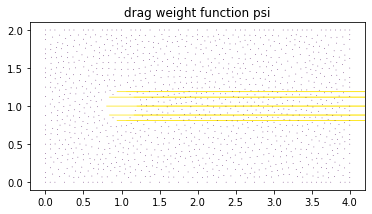

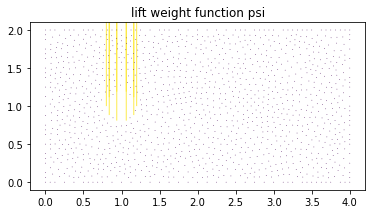

Time t = 0.03285506167650246


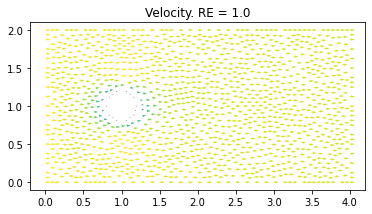

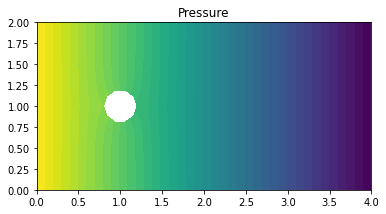

Time t = 1.018506911971576


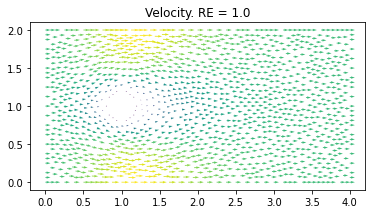

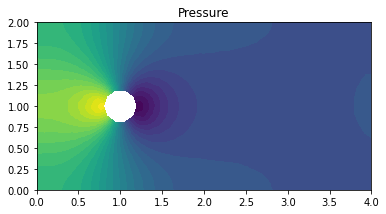

Time t = 2.004158762266649


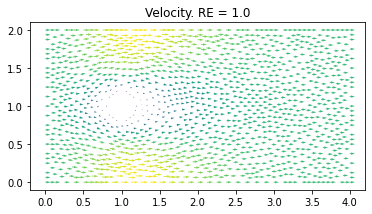

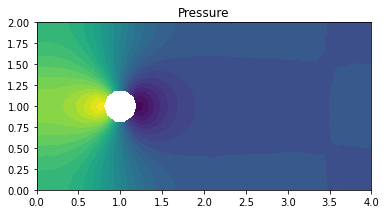

Time t = 3.022665674238231


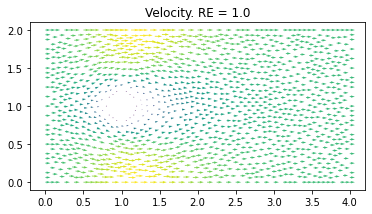

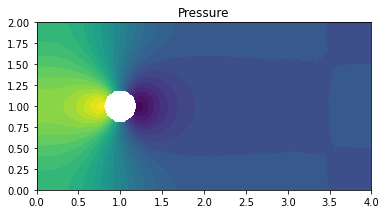

Time t = 4.00831752453331


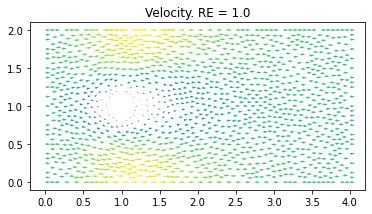

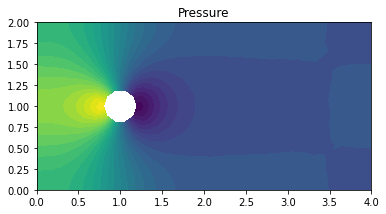

Time t = 5.026824436504892


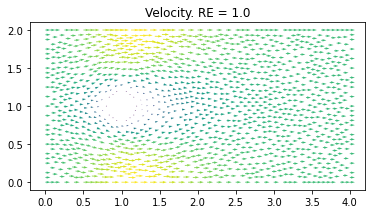

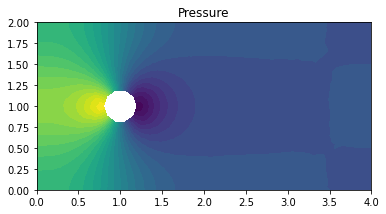

Time t = 6.012476286799972


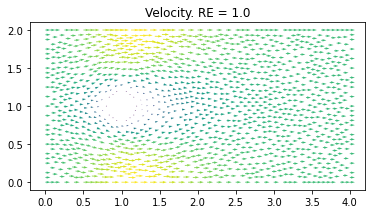

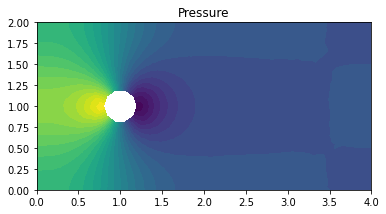

Time t = 7.030983198771554


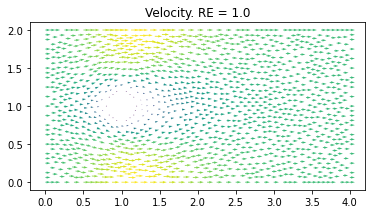

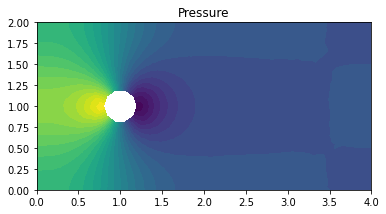

Time t = 8.016635049066632


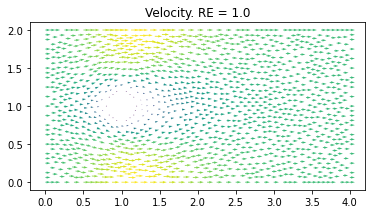

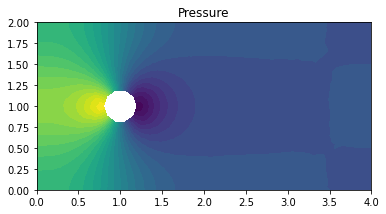

Time t = 9.002286899361685


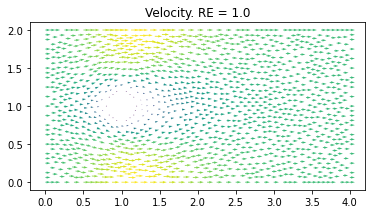

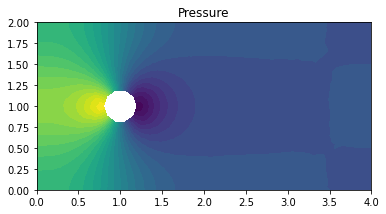

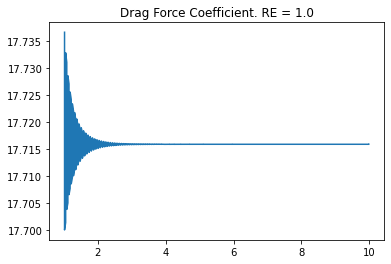

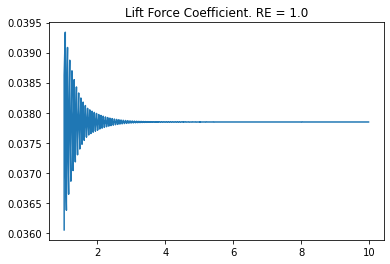

In [0]:
RE_1 = NS_Simulation()
RE_1.setup(nu = 0.4, rc=0.2)
RE_1.plot_weight_func_psi()
RE_1.time_step()

For $RE = 1$ the flow is *steady*, i.e. it does not change over time. The drag force coefficient $C_D \approx 17.72$ and the drag lift coefficient $C_L \approx 0.038$ are constant, which is expected as the flow is stable. No vortices occur due to low the low $RE$ number so we do not compute the Strouhal number.

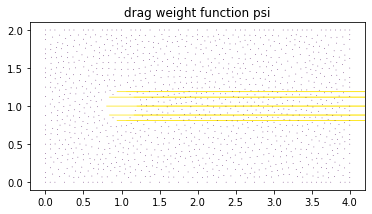

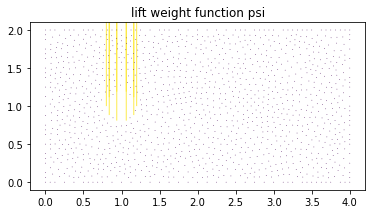

rm: cannot remove 'results-NS/*': No such file or directory
Time t = 0.03285506167650246


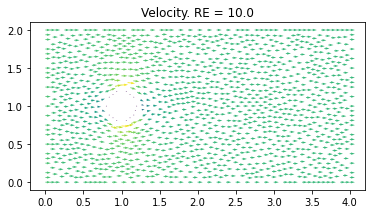

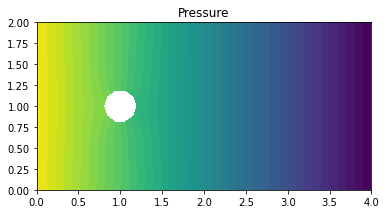

Time t = 1.018506911971576


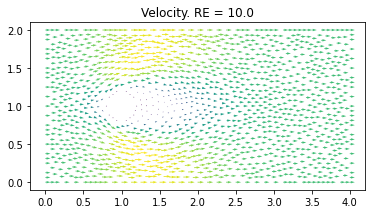

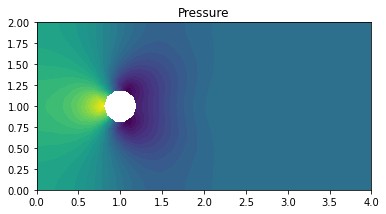

Time t = 2.004158762266649


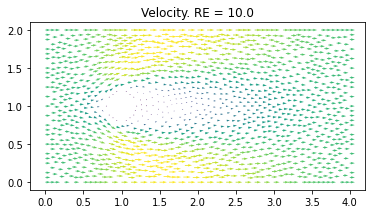

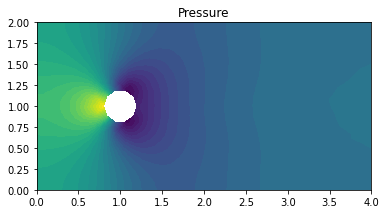

Time t = 3.022665674238231


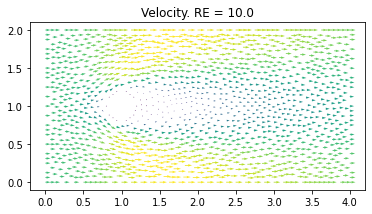

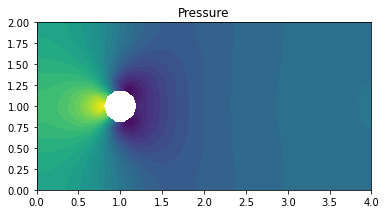

Time t = 4.00831752453331


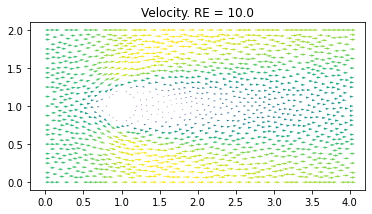

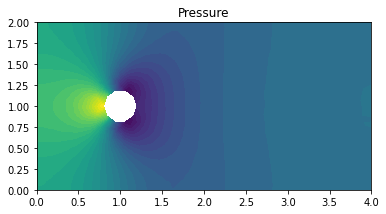

Time t = 5.026824436504892


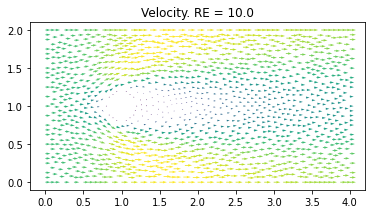

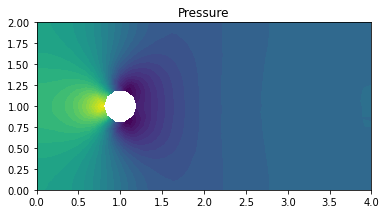

Time t = 6.012476286799972


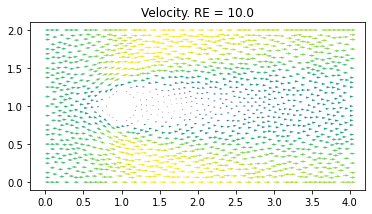

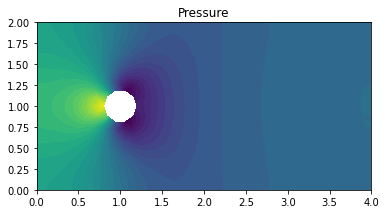

Time t = 7.030983198771554


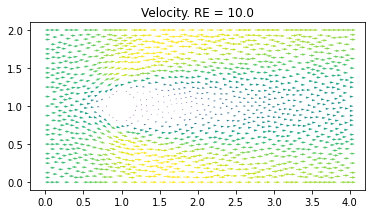

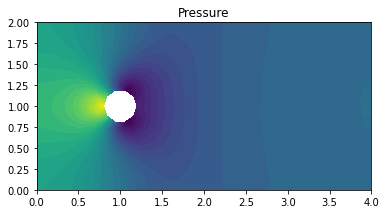

Time t = 8.016635049066632


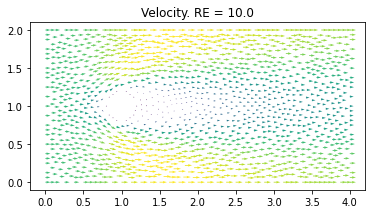

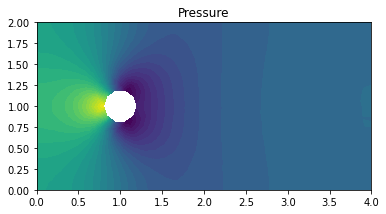

Time t = 9.002286899361685


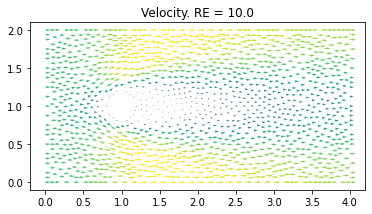

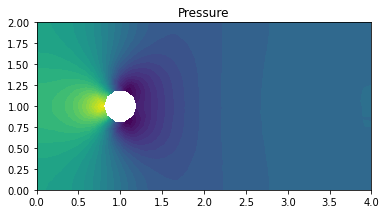

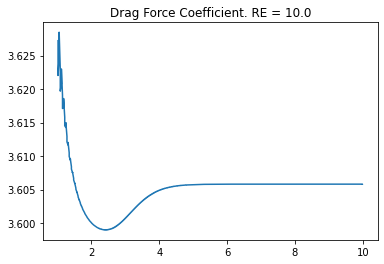

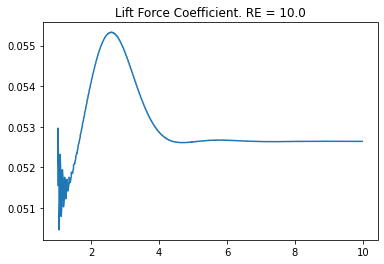

In [0]:
RE_10 = NS_Simulation()
RE_10.setup(nu = 0.04, rc=0.2)
RE_10.plot_weight_func_psi()
RE_10.time_step()

For $RE=10$ we see that the flow is steady, there are some very small fluctuations in the start of the simulation. As the flow is steady there are no vertices and we do not compute the Strouhal number.

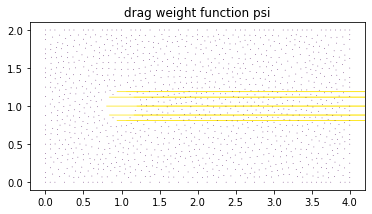

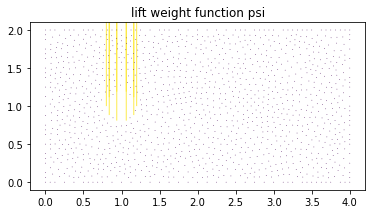

rm: cannot remove 'results-NS/*': No such file or directory
Time t = 0.03285506167650246


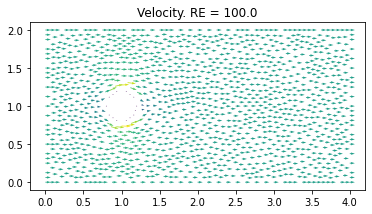

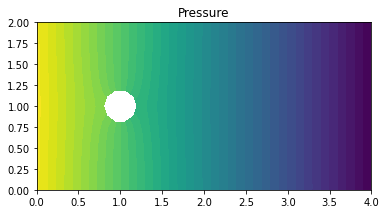

Time t = 1.018506911971576


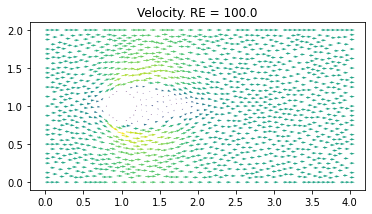

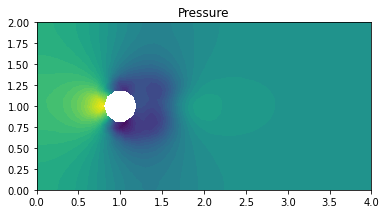

Time t = 2.004158762266649


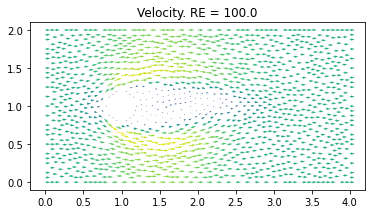

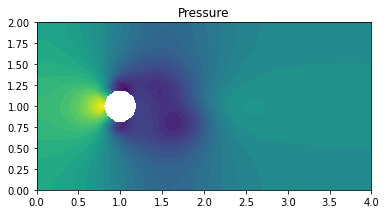

Time t = 3.022665674238231


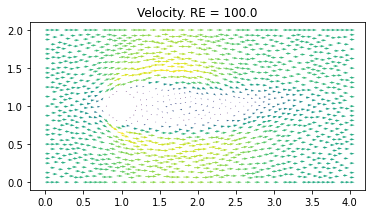

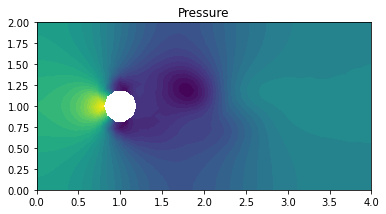

Time t = 4.00831752453331


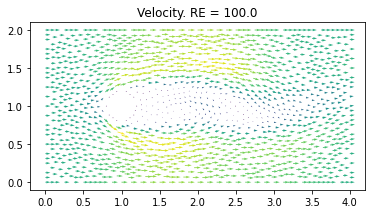

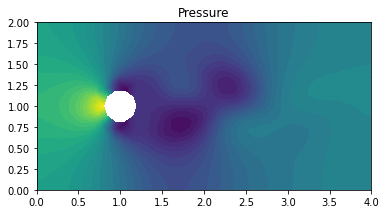

Time t = 5.026824436504892


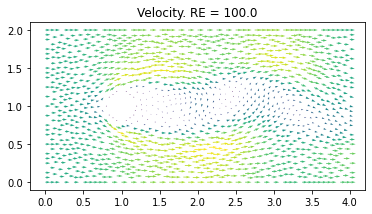

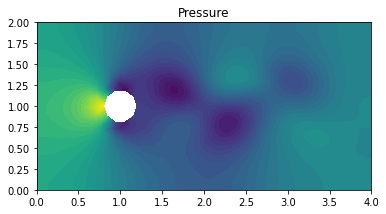

Time t = 6.012476286799972


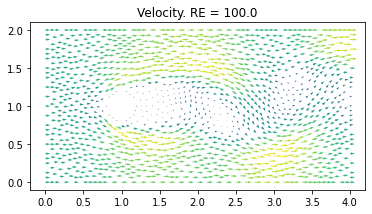

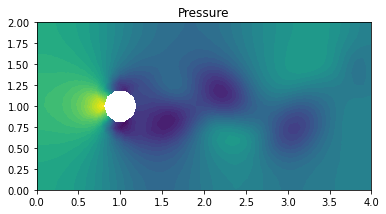

Time t = 7.030983198771554


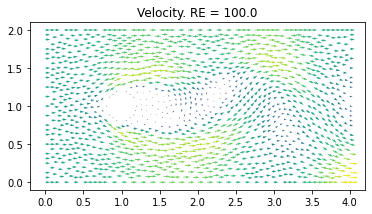

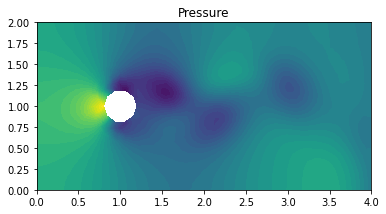

Time t = 8.016635049066632


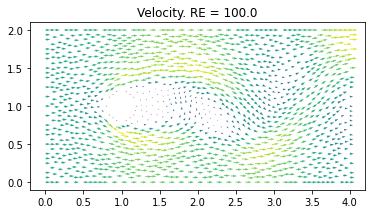

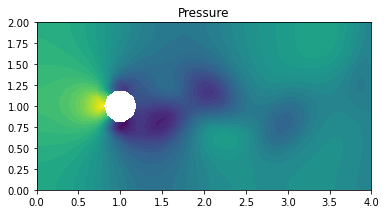

Time t = 9.002286899361685


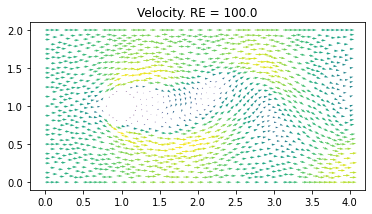

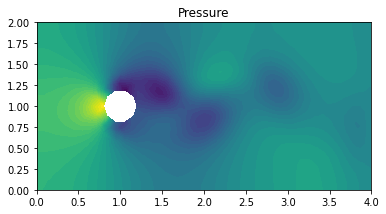

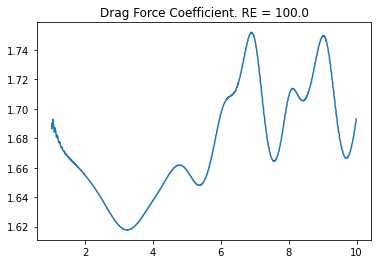

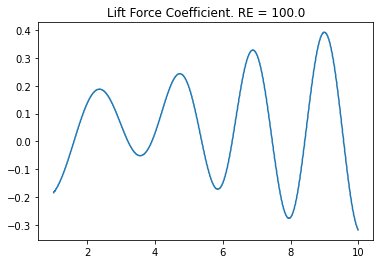

In [0]:
RE_100 = NS_Simulation()
RE_100.setup(nu = 0.004, rc=0.2)
RE_100.plot_weight_func_psi()
RE_100.time_step()

For $RE=100$ the flow is unsteady, i.e. it changes over time. The drag force coefficient has a maximum around $1.74$ and minimum at $1.62$. The amplitute of the lift force appears to be increasing over time, with a maximum value of approximately $0.4$ and minimum of $-0.3$. It is clear from the pressure plots that a von Kármán vortex street is formed, we comupte the Strohal number.

In [0]:
st, _, _ = RE_100.compute_strouhal(height=0.0)
print("STROUHAL NUMBER FOR RE=100 is: " + str(st))

STROUHAL NUMBER FOR RE=100 is: 0.17644469842591548


We get an approximated Strouhal number of $0.18$, which is quite close to the expected value of $0.22$. We continue with $RE=1000$.

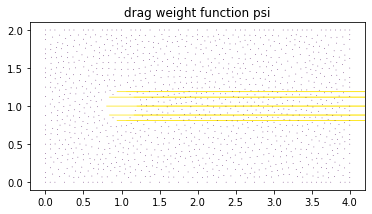

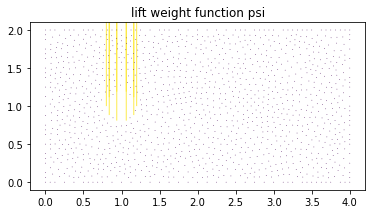

rm: cannot remove 'results-NS/*': No such file or directory
Time t = 0.03285506167650246


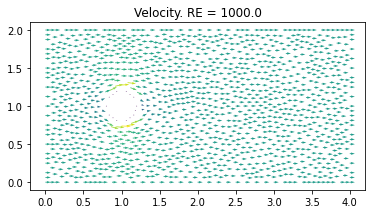

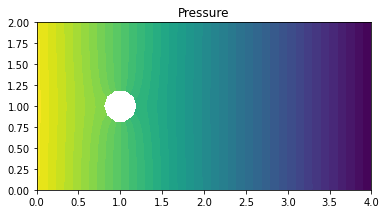

Time t = 1.018506911971576


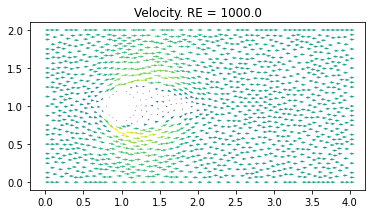

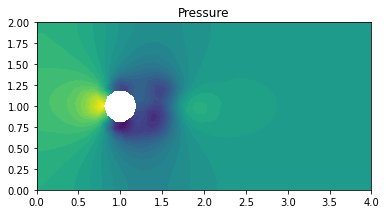

Time t = 2.004158762266649


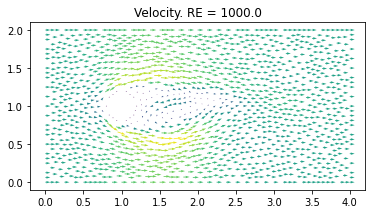

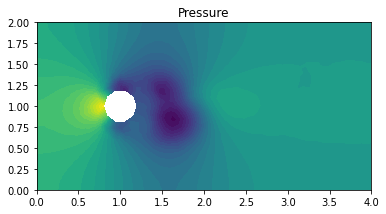

Time t = 3.022665674238231


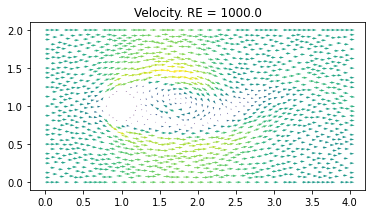

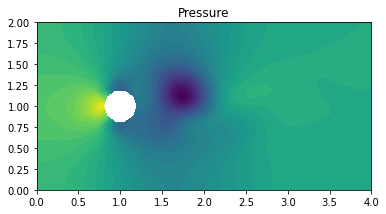

Time t = 4.00831752453331


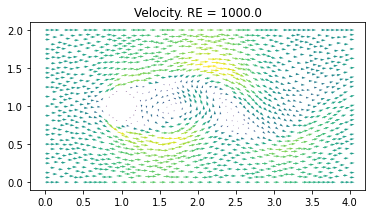

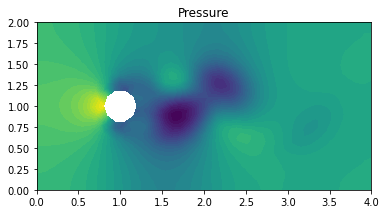

Time t = 5.026824436504892


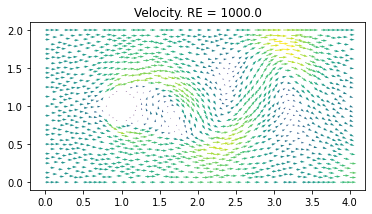

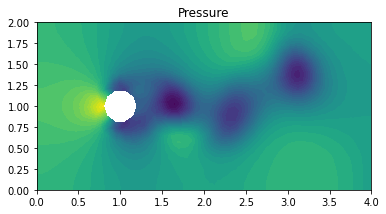

Time t = 6.012476286799972


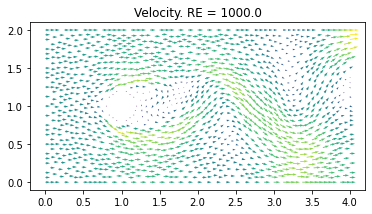

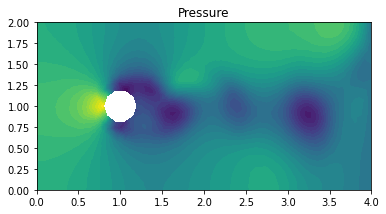

Time t = 7.030983198771554


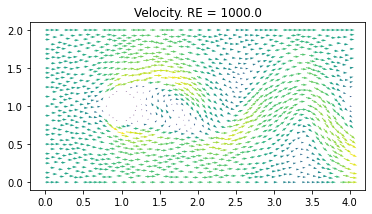

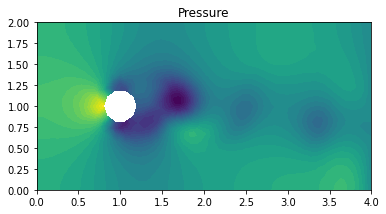

Time t = 8.016635049066632


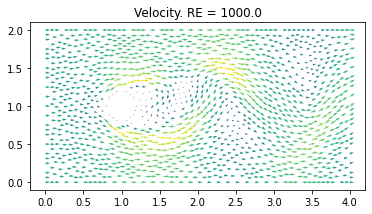

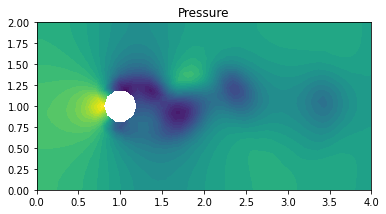

Time t = 9.002286899361685


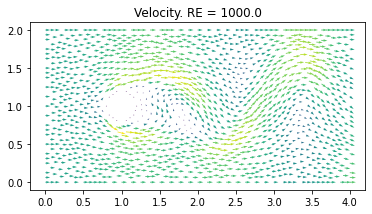

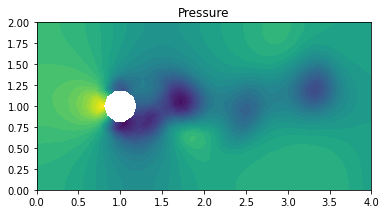

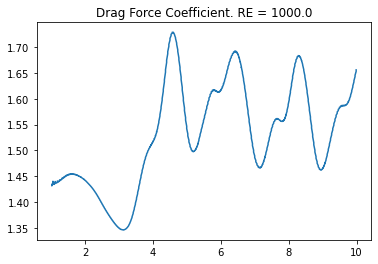

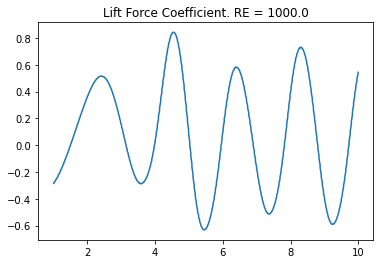

In [0]:
RE_1000 = NS_Simulation()
RE_1000.setup(nu = 0.0004, rc=0.2)
RE_1000.plot_weight_func_psi()
RE_1000.time_step()

For $RE=1000$ the flow is unsteady, the drag coefficient is very similar to $RE=100$. However, the amplitude of the lift coefficient is doubled when compared to $RE=100$, it does also not appear to increase over time. A von Kármán vortex street forms and we compute the Strohal number:

In [0]:
st, _, _ = RE_1000.compute_strouhal(height=0.0)
print("STROUHAL NUMBER FOR RE=1000 is: " + str(st))

STROUHAL NUMBER FOR RE=1000 is: 0.20123444944443253


The Strouhal number, $st \approx 0.20$, is now very close to the expected value of $0.22$.

## **Changing Mesh Resolution**

We will not investigate how the simulation changes when the resolution of the mesh is altered, a Reynolds number of $100$ is used. The simulation is run for four different resolution values,  $h=\ 1/8, \ 1/16, \ 1/32$, note that we have already run the simulation for $h=1/32$ and $RE=100$ above. We start with $h=1/8$:

In [0]:
RES_8 = NS_Simulation()
RES_8.setup(nu = 0.004, rc=0.2, resolution=8)

Which gives the mesh,

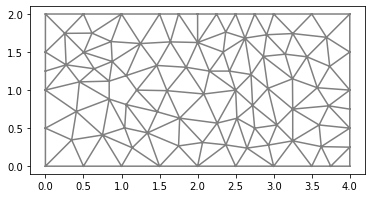

In [0]:
RES_8.plot_mesh()

The cylinder obstacle is hardly visible.

rm: cannot remove 'results-NS/*': No such file or directory
Time t = 0.13091486480653436


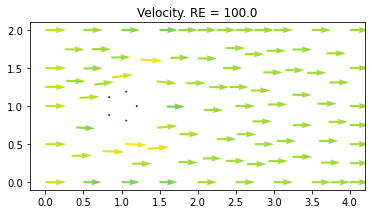

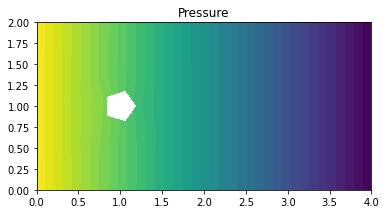

Time t = 1.0473189184522749


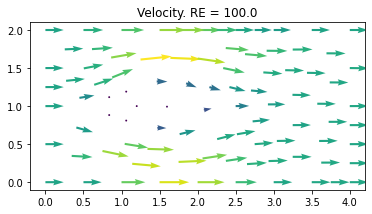

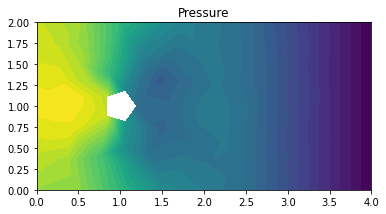

Time t = 2.0946378369045497


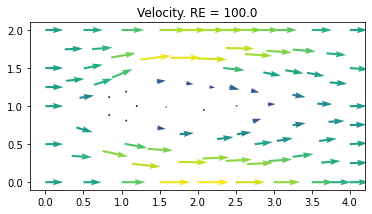

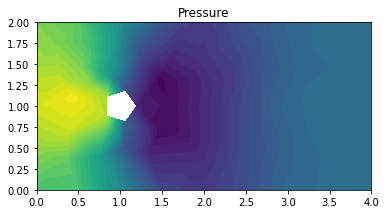

Time t = 3.011041890550292


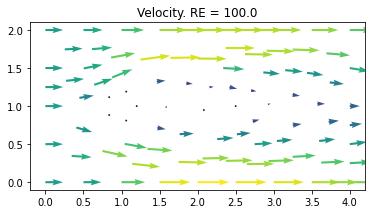

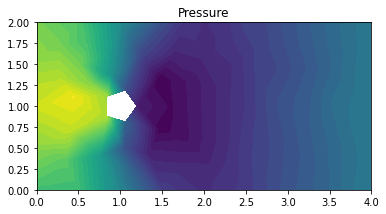

Time t = 4.0583608090025685


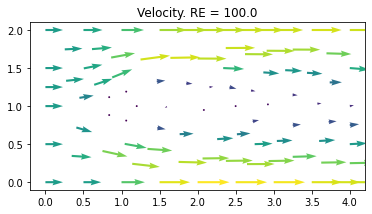

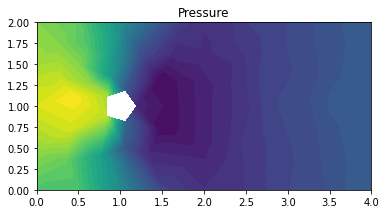

Time t = 5.105679727454845


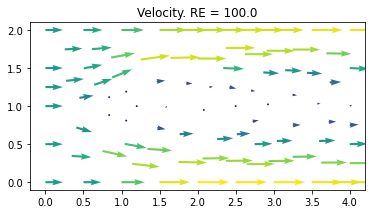

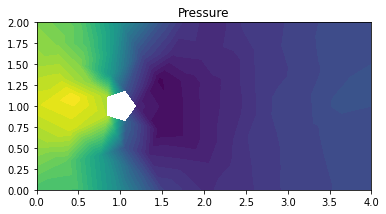

Time t = 6.022083781100587


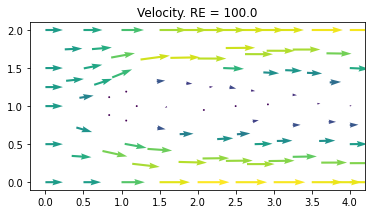

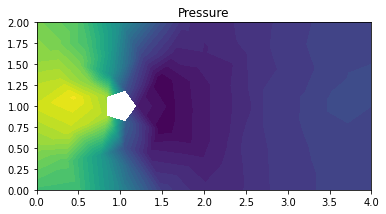

Time t = 7.069402699552864


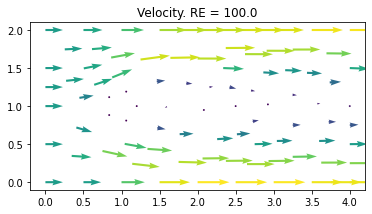

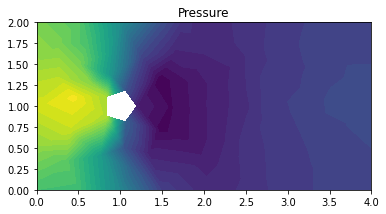

Time t = 8.11672161800514


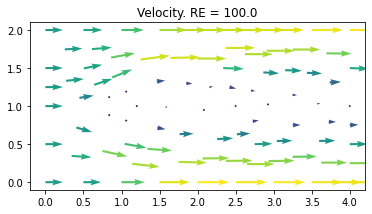

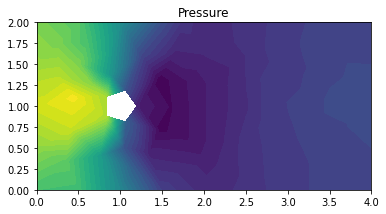

Time t = 9.033125671650883


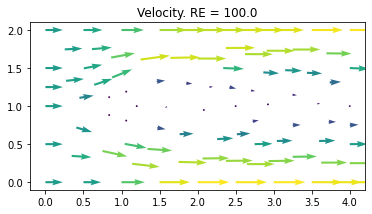

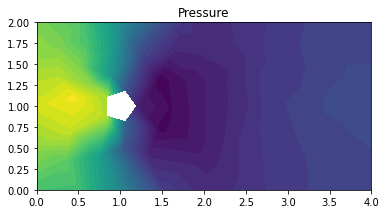

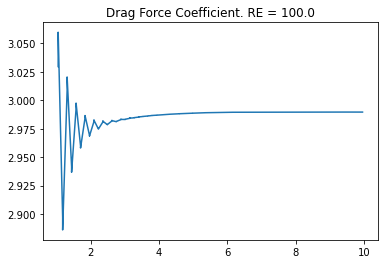

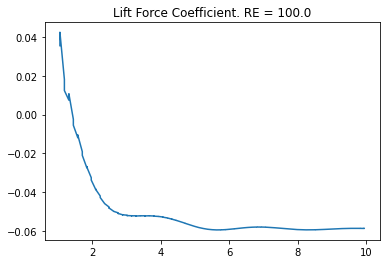

In [0]:
RES_8.time_step()

The low resolution makes the flow appear stable and the drag- and lift coefficients converge quickly to a constant value, approximately $2.99$ for the drag coefficient and $-0.06$ for the lift force coefficient. As the flow is stable there is no von Kármán vortex street and we do not compute the Strouhal number. We continue with $h=1/16$:

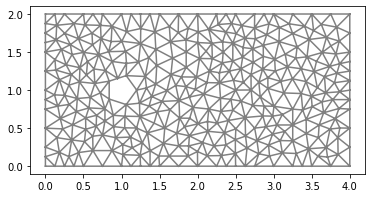

In [0]:
RES_16 = NS_Simulation()
RES_16.setup(nu = 0.004, rc=0.2, resolution=16)
RES_16.plot_mesh()

rm: cannot remove 'results-NS/*': No such file or directory
Time t = 0.06628038350651762


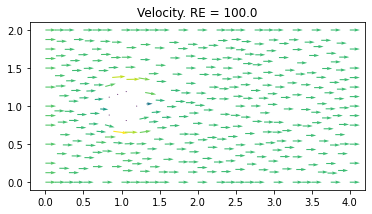

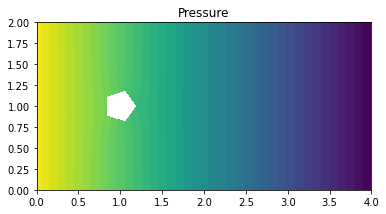

Time t = 1.060486136104282


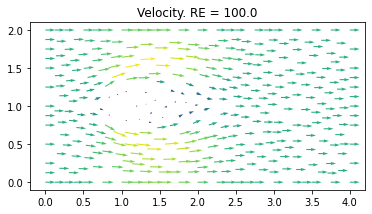

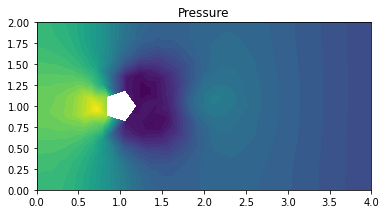

Time t = 2.0546918887020453


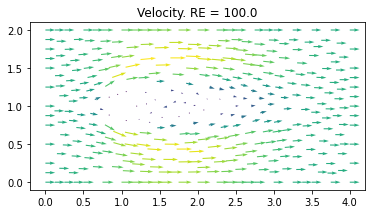

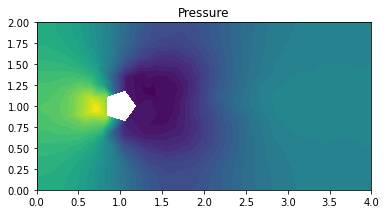

Time t = 3.0488976412998086


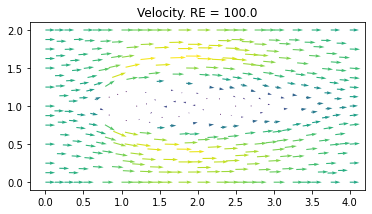

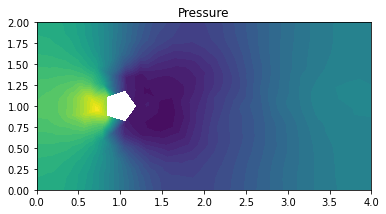

Time t = 4.043103393897572


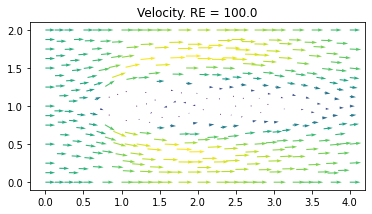

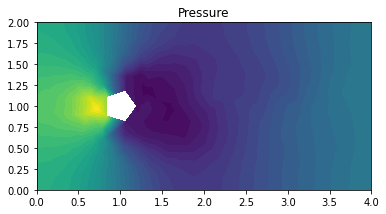

Time t = 5.037309146495342


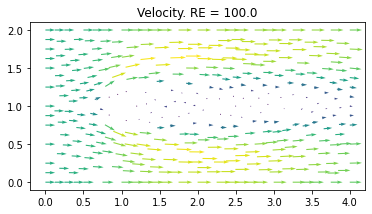

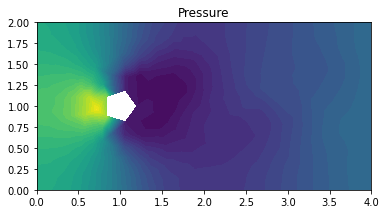

Time t = 6.031514899093112


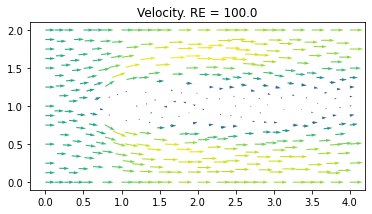

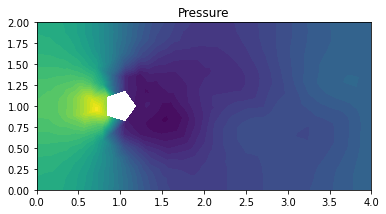

Time t = 7.0257206516908814


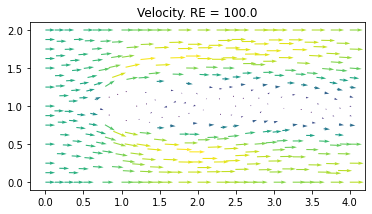

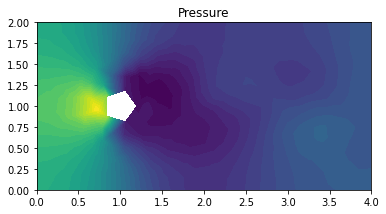

Time t = 8.01992640428865


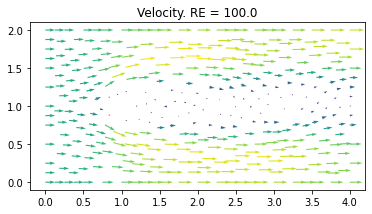

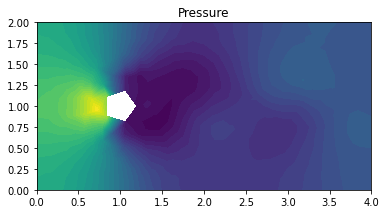

Time t = 9.01413215688642


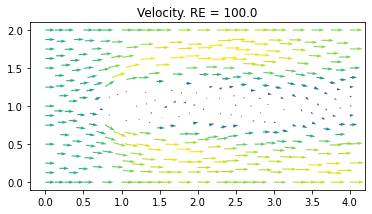

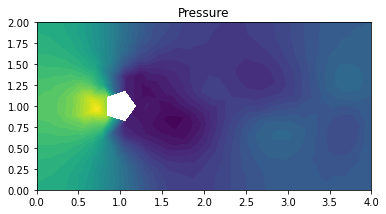

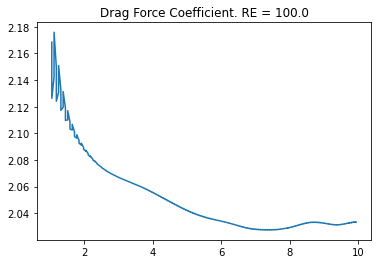

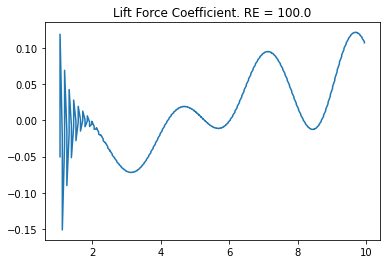

In [0]:
RES_16.time_step()

The drag force coefficient is smaller then for $h=1/8$ but slightly larger compared to $h=1/32$, there also appears to be some oscilation in the lift force and there seems to be an outline of a von Kármán vortex street. We now want to compute the Strouhal number, but due to the instability during the start of the simulation we cannot use the *compute_strouhal()* function directly. However, one of the return values functions is the time for the peaks:

In [0]:
_, _, times = RES_16.compute_strouhal(distance=100, height=0.0)
print(times)

[1.06048614 4.70590723 7.15828142]


The first value is noise so we use the last two to compute the frequency,
$$
f \approx \frac{1}{7.158 - 4.706} \approx 0.408,
$$
which gives the Strouhal number,
$$
st \approx 0.408\cdot 0.4 = 0.1632.
$$
Which is quite close to $0.22$, but not as close as for $h=1/32$.


### **ParaView Movies**
Two animations were also generated, for the pressure and velocity where $RE=100$ and $h=1/32$. However, I was not able to display them here without the files being deleted after each runtime session. The two avi files are uploaded to github toghether with the report.

# **Discussion**

A stabilized finite element method was implemented in FEniCS to solve the Navier-Stokes equations in 2D. The method was tested for the model problem of flow past a circular obstacle, and for a high enough Reynolds number and sufficient mesh resolution [a von Karman vortex street developed as expected.](https://en.wikipedia.org/wiki/Kármán_vortex_street)

For lower mesh resolutions the solution clearly deterioates so it important to refine the mesh so it is fine enough for the domain and parameters.